In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
import pylab
from datetime import datetime
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.copula_model import *
from src.signal_generation import *
from src.backtesting import *
from src.pair_selection import *


from pathlib import Path
os.chdir("/Users/emmanueladeleye/Documents/Quants Projects/Statistical Arbitrage/Pairs-Trading-Statistical-Arbitrage")

In [2]:
prices = pd.read_csv("data/etfs/combined_etfs.csv", index_col=0, parse_dates=True)
cleaned_prices = pd.read_csv("data/processed/cleaned_prices.csv", index_col=0, parse_dates=True)
returns = pd.read_csv("data/processed/log_returns.csv")

#### **Running Pair Selection**

In [3]:
selector = PairSelector(prices, returns)


Train/Test Split:
  Training period: 2015-01-02 00:00:00 to 2020-12-31 00:00:00
  Training days: 1542
  Testing period: 2020-12-31 00:00:00 to 2021-12-31 00:00:00
  Testing days: 259


In [4]:
selector.run_selection()


PAIR SELECTION (TRAINING PHASE)
Correlation threshold set at: 0.9518 (Percentile: 95th, Abs Min: 0.7)
  Selected 248 pairs with correlation >= 0.9518

Cointegration testing (p-value < 0.01):
Found 35 cointegrated pairs

 Copula Fitting and Scoring..
Fitted CRM_XLV: Student_t copula, LL: 1395.46, Lower tail: 0.106
Fitted XLB_EWJ: Gaussian copula, LL: 1553.80, Lower tail: 0.000
Fitted EWC_EWA: Gaussian copula, LL: 2152.89, Lower tail: 0.000
Fitted WMT_XLV: Student_t copula, LL: 1342.04, Lower tail: 0.659
Fitted LIN_XLV: Student_t copula, LL: 1601.53, Lower tail: 0.691
Fitted VTI_RIO: Student_t copula, LL: 1521.20, Lower tail: 0.241
Fitted LIN_XLY: Student_t copula, LL: 40395.82, Lower tail: 0.897
Fitted WMT_LIN: Student_t copula, LL: 1665.92, Lower tail: 0.549
Fitted ACWI_RIO: Gaussian copula, LL: 1741.83, Lower tail: 0.000
Fitted ADBE_XLV: Student_t copula, LL: 1244.39, Lower tail: 0.296
Fitted CRM_LIN: Student_t copula, LL: 48031.59, Lower tail: 0.856
Fitted PEP_XLU: Student_t copula,

[{'ETF1': 'XLB',
  'ETF2': 'EWJ',
  'Correlation': 0.9534227756535153,
  'P-Value': 0.0006616557209491009,
  'Half_life': 25.956791527569287,
  'Hedge_ratio': 1.2364096035875352,
  'composite_score': np.float64(0.8370187733311225),
  'coint_score': np.float64(0.9338344279050899),
  'half_life_score': np.float64(0.5670051979285917),
  'll_score': np.float64(1.0),
  'copula_type': 'Gaussian',
  'tail_dependence': 0.0,
  'copula_model': {'marginal_1': {'cdf': <function src.copula_model.CopulaModel.fit_marginal_distributions.<locals>.cdf(x)>,
    'ppf': <function src.copula_model.CopulaModel.fit_marginal_distributions.<locals>.ppf(u)>,
    'params': {'df': np.float64(17799640.246107165),
     'loc': np.float64(46.041034238171335),
     'scale': np.float64(6.9744463227650595)},
    'type': 'student_t'},
   'marginal_2': {'cdf': <function src.copula_model.CopulaModel.fit_marginal_distributions.<locals>.cdf(x)>,
    'ppf': <function src.copula_model.CopulaModel.fit_marginal_distributions.<loc

In [5]:
selected_pairs = selector.selected_pairs

In [6]:
all_pairs = {}

etf1 = []
etf2 = []
hl = []
pv = []
hr = []
cs = []
cm = []
for i in range(len(selected_pairs)):
    etf1.append(selected_pairs[i]["ETF1"])
    etf2.append(selected_pairs[i]["ETF2"])
    hl.append(selected_pairs[i]["Half_life"])
    pv.append(selected_pairs[i]["P-Value"])
    hr.append(selected_pairs[i]["Hedge_ratio"])
    cs.append(selected_pairs[i]["composite_score"])

all_pairs = {"ETF1":etf1, "ETF2":etf2, "Half_life":hl, "p-value":pv, "Hedge_ratio":hr, "Composite_score":cs}    

In [7]:
selected_pairs_df = pd.DataFrame(all_pairs).sort_values(by="Composite_score", ascending=False)

In [8]:
selected_pairs_df

,ETF1,ETF2,Half_life,p-value,Hedge_ratio,Composite_score
0,XLB,EWJ,25.956792,0.000662,1.236410,0.837019
1,CRM,XLV,25.662480,0.000366,3.717445,0.835663
2,VTI,RIO,37.945450,0.001725,2.711695,0.821451
3,EWC,EWA,14.918505,0.000791,1.268974,0.801950
4,ACWI,RIO,36.103074,0.002143,1.065419,0.794304
5,ADBE,XLV,25.680054,0.002230,9.139050,0.722516
6,SPY,RIO,41.166489,0.004394,5.366504,0.685742
7,IWDA.L,RIO,25.030409,0.003774,0.934281,0.678432
8,VOO,RIO,40.765517,0.004529,4.937373,0.677099
9,VEU,VWO,37.469127,0.006851,1.025939,0.563527


#### **Pair Spread Analysis**

In [9]:
def spread_analysis(etf1, etf2, hr, hl, data):

    # Load data
    etf1_prices = data[etf1].dropna()
    etf2_prices = data[etf2].dropna()
    common_indices = etf1_prices.index.intersection(etf2_prices.index)
    etf1_prices = etf1_prices.loc[common_indices]
    etf2_prices = etf2_prices.loc[common_indices]
    
    # Calculate spread
    spread = etf1_prices - hr * etf2_prices   
    spread_ret = spread.pct_change().dropna()

    etf1_returns = etf1_prices.pct_change().dropna()
    etf2_returns = etf2_prices.pct_change().dropna()

    coint_score, pvalue, _ = coint(etf1_prices, etf2_prices)

    adf_stat, adf_pvalue, adf_lags, adf_nobs, adf_critical, _ = adfuller(
        spread, maxlag=None, regression="c", autolag="AIC"
    )

    fig = plt.figure(figsize=(20,12))
    gs = fig.add_gridspec(3,3, hspace=0.3, wspace=0.3)

    ax1 = fig.add_subplot(gs[0,:])
    etf1_norm = etf1_prices / etf1_prices.iloc[0] * 100
    etf2_norm = etf2_prices / etf2_prices.iloc[0] * 100
    ax1.plot(etf1_norm.index, etf1_norm, label=etf1, linewidth=1.5, alpha=0.5)
    ax1.plot(etf1_norm.index, etf2_norm, label=etf2, linewidth=1.5, alpha=0.5)
    ax1.set_title(f"{etf1}_{etf2} - Normalizaed Prices", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Normalized Price")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(gs[1, :])
    mean_spread = spread.mean()
    std_spread = spread.std()
    ax2.axhline(mean_spread, color="red", linestyle="--", label=f"Mean: {mean_spread:.2f}")
    ax2.axhline(mean_spread + 2*std_spread, color="orange", linestyle="--", alpha=0.7, label="±2σ")
    ax2.axhline(mean_spread - 2*std_spread, color="orange", linestyle="--", alpha=0.7)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Spread Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = fig.add_subplot(gs[2,0])
    ax3.hist(spread, bins=50, alpha=0.7, color="purple", edgecolor="k")
    ax3.axvline(spread.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax3.set_title('Spread Distribution', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Spread Value')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)


    ax4 = fig.add_subplot(gs[2,1])
    stats.probplot(spread_ret, dist="norm", plot=ax4)
    ax4.set_title('Spread Returns Q-Q Plot', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # Autocorrelation of spread
    ax5 = fig.add_subplot(gs[2,2])
    from pandas.plotting import autocorrelation_plot
    autocorrelation_plot(spread, ax=ax5)
    ax5.set_title('Spread Autocorrelation', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Lag')
    ax5.set_ylabel('Autocorrelation')
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n" + "="*70)
    print(f"PAIR ANALYSIS: {etf1} vs {etf2}")
    print("="*70)

    print("\nSpread Stationarity (ADF Test):")
    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"p-value: {adf_pvalue:.6f}")
    print(f"Critical Values:")
    for key, value in adf_critical.items():
        print(f"    {key}: {value:.4f}")
    print(f"  {'STATIONARY' if adf_pvalue < 0.05 else 'NOT STATIONARY'} (α=0.05)")

    print("\nMean Reversion & Trading Suitability:")
    print(f"Half-life: {hl:.2f} days")
    print(f"Spread Mean: {spread.mean():.4f}")
    print(f"Spread Std Dev: {spread.std():.4f}")
    print(f"Spread Range: [{spread.min():.4f}, {spread.max():.4f}]")
    print("-"*60)
    suitable = (pvalue<0.05 and adf_pvalue<0.05 and 5<hl<100)
    print(f"{'Suitable for pairs trading' if suitable else 'Not Suitable'} ")
    if not suitable:
        if pvalue >= 0.05:
            print(f"Not cointegrated")
        if adf_pvalue >= 0.05:
            print("Not Stationary")
        if hl <=5:
            print("Half life too short (overtrading risk)")
        if hl>=100:
            print("Half life too long (slow mean reversion)")

    return {
        'hedge_ratio': hr,
        'coint_pvalue': pvalue.item(),
        'adf_pvalue': adf_pvalue.item(),
        'half_life': hl,
        'spread_mean': spread.mean().item(),
        'spread_std': spread.std(),
        'suitable': suitable
    }

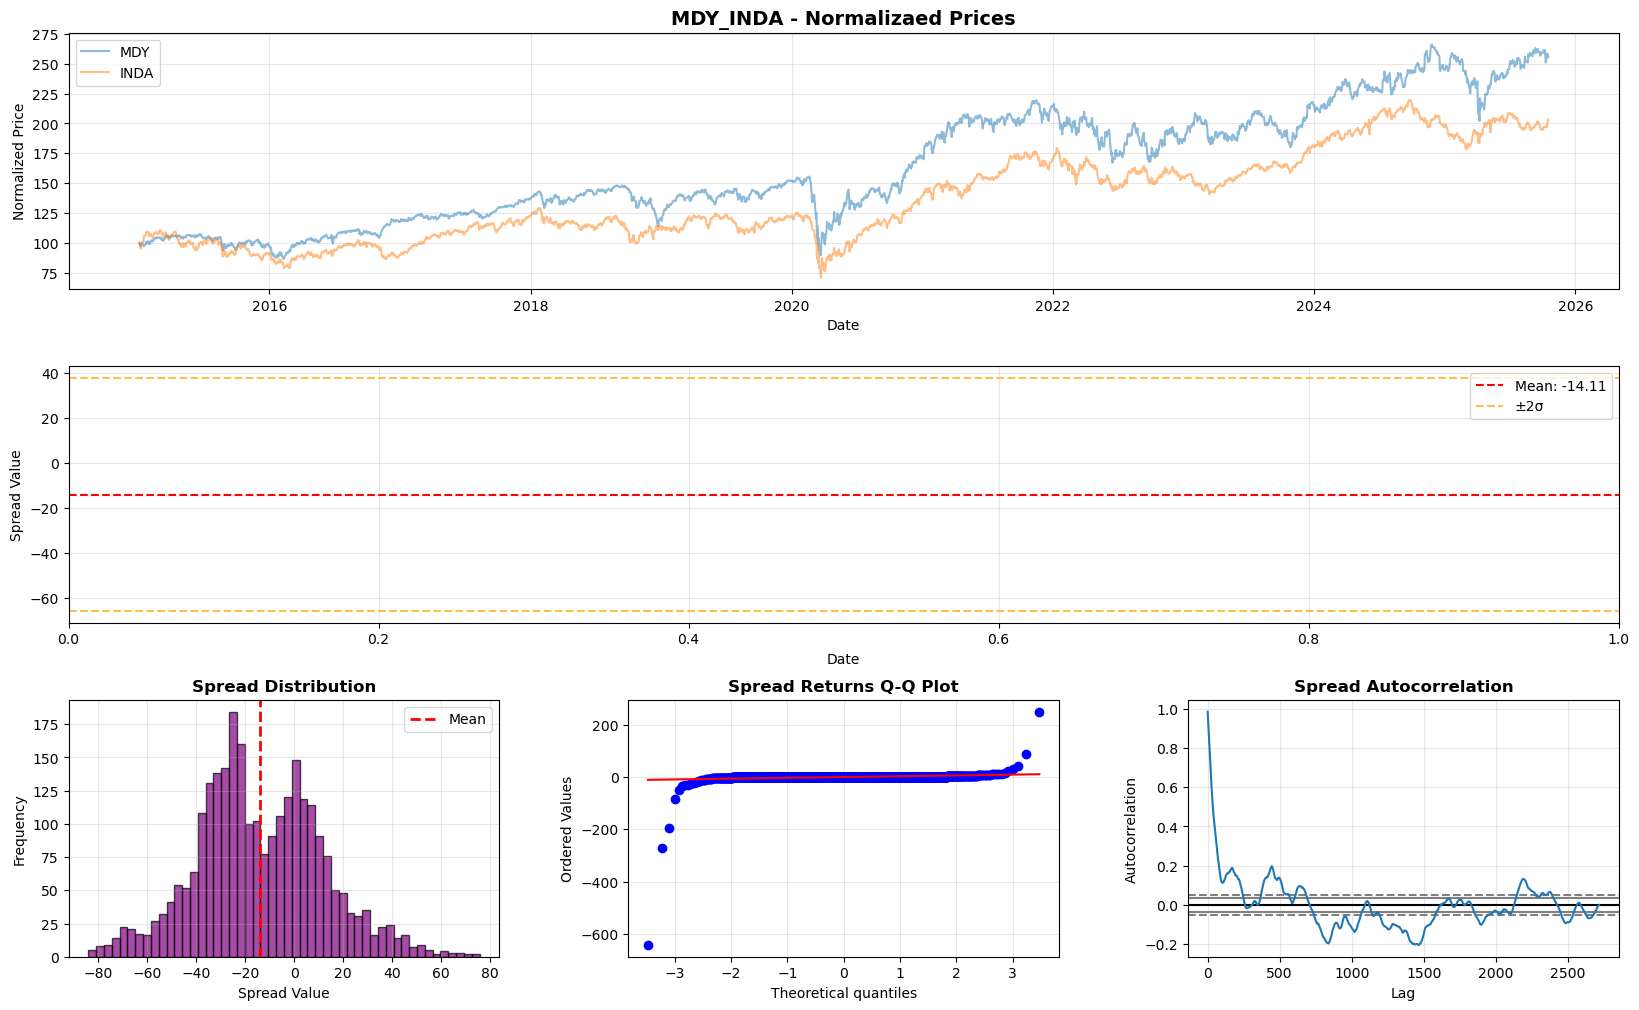


PAIR ANALYSIS: MDY vs INDA

Spread Stationarity (ADF Test):
ADF Statistic: -4.6348
p-value: 0.000111
Critical Values:
    1%: -3.4328
    5%: -2.8626
    10%: -2.5673
  STATIONARY (α=0.05)

Mean Reversion & Trading Suitability:
Half-life: 46.65 days
Spread Mean: -14.1148
Spread Std Dev: 25.9939
Spread Range: [-84.1176, 75.6790]
------------------------------------------------------------
Suitable for pairs trading 


{'hedge_ratio': 10.698498,
 'coint_pvalue': 0.0010717046892424675,
 'adf_pvalue': 0.00011137469241234975,
 'half_life': 46.654654,
 'spread_mean': -14.114822437366609,
 'spread_std': 25.993926999117825,
 'suitable': True}

In [10]:
spread_analysis("MDY", "INDA", 10.698498, 46.654654, prices)

#### **Pair Copula Analysis**

In [11]:
# def backtest_analysis(top=None, bottom=None):

In [12]:
copula_data = []
for pair in selected_pairs:
    pair_name = f"{pair["ETF1"]}_{pair["ETF2"]}"
    model = pair.get("copula_model")

    if model:
        copula_data.append({
            "pair": pair_name,
            "copula_type": model["copula_type"],
            "log_likelihood": model["log_likelihood"],
            "lower_tail_dep": model["lower_tail_dependence"],
            "upper_tail_dep": model["upper_tail_dependence"]
        })

df = pd.DataFrame(copula_data)

In [13]:
df

,pair,copula_type,log_likelihood,lower_tail_dep,upper_tail_dep
0,XLB_EWJ,Gaussian,1553.798873,0.000000,0.000000
1,CRM_XLV,Student_t,1395.456020,0.106369,0.106369
2,VTI_RIO,Student_t,1521.203410,0.241372,0.241372
3,EWC_EWA,Gaussian,2152.890587,0.000000,0.000000
4,ACWI_RIO,Gaussian,1741.830783,0.000000,0.000000
5,ADBE_XLV,Student_t,1244.390256,0.296232,0.296232
6,SPY_RIO,Student_t,1407.257342,0.216152,0.216152
7,IWDA.L_RIO,Student_t,1515.062440,0.174345,0.174345
8,VOO_RIO,Student_t,1403.759527,0.209931,0.209931
9,VEU_VWO,Student_t,2364.751629,0.380836,0.380836


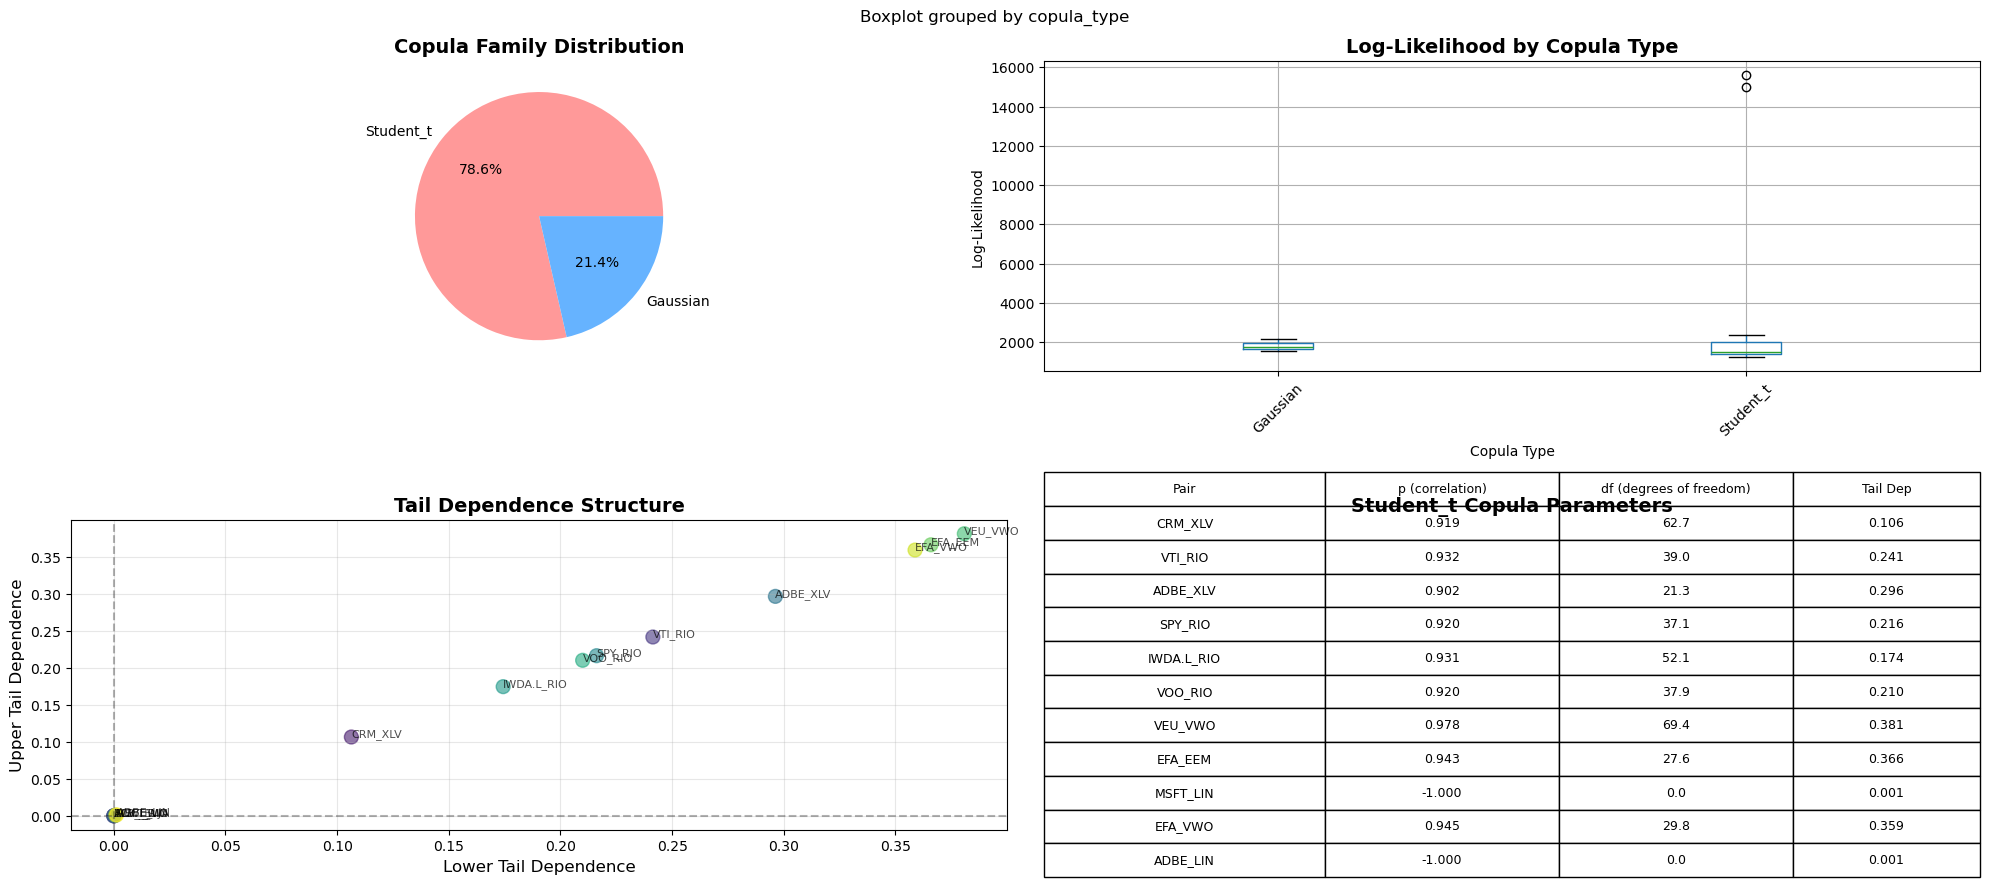

In [14]:
fig, axes = plt.subplots(2,2, figsize=(20,9))

copula_counts = df["copula_type"].value_counts()
axes[0, 0].pie(copula_counts, labels=copula_counts.index, autopct="%1.1f%%", colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc'])
axes[0, 0].set_title('Copula Family Distribution', fontsize=14, fontweight='bold')

df.boxplot(column="log_likelihood", by="copula_type", ax=axes[0,1])
axes[0,1].set_title("Log-Likelihood by Copula Type", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel('Copula Type')
axes[0, 1].set_ylabel('Log-Likelihood')
plt.sca(axes[0, 1])
plt.xticks(rotation=45)

axes[1,0].scatter(df["lower_tail_dep"], df["upper_tail_dep"],
                                            s=100, alpha=0.6, c=range(len(df)), cmap="viridis")
for idx, row in df.iterrows():
    axes[1,0].annotate(row["pair"], (row["lower_tail_dep"], row["upper_tail_dep"]), fontsize=8, alpha=0.7)
axes[1, 0].set_xlabel('Lower Tail Dependence', fontsize=12)
axes[1, 0].set_ylabel('Upper Tail Dependence', fontsize=12)
axes[1, 0].set_title('Tail Dependence Structure', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].axvline(x=0, color='k', linestyle='--', alpha=0.3)

student_pairs = [p for p in selected_pairs if p.get("copula_model", {}).get("copula_type")=="Student_t"]

if student_pairs:
    param_data = []
    for pair in student_pairs:
        model = pair["copula_model"]
        copula = model["copula"]
        params = copula.params

        pair_name = f"{pair["ETF1"]}_{pair["ETF2"]}"
        rho = float(params.rho[0].item()) if isinstance(params.rho, np.ndarray) else float(params.rho)
        p_df = float(params.df.item())

        param_data.append({
            "Pair": pair_name,
            "p (correlation)": f"{rho:.3f}",
            "df (degrees of freedom)": f"{p_df:.1f}",
            "Tail Dep": f"{model['lower_tail_dependence']:.3f}"
        })
    param_df = pd.DataFrame(param_data)

    # Display table
    axes[1,1].axis("tight")
    axes[1,1].axis("off")
    table = axes[1,1].table(cellText=param_df.values,
                            colLabels=param_df.columns,
                            cellLoc="center",
                            loc="center",
                            colWidths=[0.3,0.25,0.25,0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1,2)
    axes[1,1].set_title("Student_t Copula Parameters", fontsize=14, fontweight="bold")

else:
    axes[1,1].text(0.5, 0.5, "No Student-t Copulas", ha="center", va="center", fontsize=14)
    axes[1,1].axis("off")
plt.tight_layout()
plt.show()

In [15]:
# Print summary statistics
print("\n" + "="*70)
print("COPULA MODEL SUMMARY")
print("="*70)
print(f"\nTotal Pairs Analysed: {len(df)}")
print("\nCopula Family Breakdown:")
for copula_type, count in copula_counts.items():
    pct = count/len(df) * 100
    print(f"{copula_type}: {count} pairs ({pct:.1f}%)")
print("\nLog-Likelihood Statistics")
print(f"Mean: {df['log_likelihood'].mean():.2f}")
print(f"Median: {df['log_likelihood'].median():.2f}")
print(f"Range: [{df['log_likelihood'].min():.2f}, {df['log_likelihood'].max():.2f}]")

print("\nTail Dependence:")
print(f"Lower Tail - Mean: {df['lower_tail_dep'].mean():.3f}, Max: {df['lower_tail_dep'].max():.3f}")
print(f"Upper Tail - Mean: {df['upper_tail_dep'].mean():.3f}, Max: {df['upper_tail_dep'].max():.3f}")

# Symmetric vs Asymmetric
symmetric = df[df["copula_type"].isin(["Student_t", "Gaussian"])]
asymmetric = df[~df["copula_type"].isin(["Student_t","Gaussian"])]

print(f"\nSymmetric Copulas (Student-t, Gaussian): {len(symmetric)} ({len(symmetric)/len(df)*100:.1f}%)")
print(f"\nSymmetric Copulas (Student-t, Gaussian): {len(symmetric)} ({len(symmetric)/len(df)*100:.1f}%)")

if len(asymmetric) > 0:
    print("\nWarning: Asymmetric copulas detected")
    print("Pairs with asymmetric dependence may not be ideal for mean-reversion trading")
    print("Consider filtering for Student-t or Gaussian copulas only")


COPULA MODEL SUMMARY

Total Pairs Analysed: 14

Copula Family Breakdown:
Student_t: 11 pairs (78.6%)
Gaussian: 3 pairs (21.4%)

Log-Likelihood Statistics
Mean: 3588.81
Median: 1601.12
Range: [1244.39, 15600.30]

Tail Dependence:
Lower Tail - Mean: 0.168, Max: 0.381
Upper Tail - Mean: 0.168, Max: 0.381

Symmetric Copulas (Student-t, Gaussian): 14 (100.0%)

Symmetric Copulas (Student-t, Gaussian): 14 (100.0%)


#### **Backtest Analysis**

In [16]:
signal_gen = SignalGenerator()
test_prices, test_returns = selector.get_test_data()
signals = signal_gen.generate_batch_signals(test_prices, selected_pairs)

Generating signals for XLB_EWJ (using Gaussian)...
  Successful calculations: 165
  Generated 5 entry signals
Generating signals for CRM_XLV (using Student_t)...
  Successful calculations: 165
  Generated 5 entry signals
Generating signals for VTI_RIO (using Student_t)...
  Successful calculations: 165
  Generated 5 entry signals
Generating signals for EWC_EWA (using Gaussian)...
  Successful calculations: 165
  Generated 5 entry signals
Generating signals for ACWI_RIO (using Gaussian)...
  Successful calculations: 165
  Generated 5 entry signals
Generating signals for ADBE_XLV (using Student_t)...
  Successful calculations: 165
  Generated 5 entry signals
Generating signals for SPY_RIO (using Student_t)...
  Successful calculations: 165
  Generated 5 entry signals
Generating signals for IWDA.L_RIO (using Student_t)...
  Successful calculations: 162
  Generated 5 entry signals
Generating signals for VOO_RIO (using Student_t)...
  Successful calculations: 165
  Generated 5 entry signals

In [17]:
backtester = Backtester(
        signals_dict=signals,
        prices_df=test_prices,
        selected_pairs=selected_pairs,
        initial_capital=100_000,
        tcost_bps=5,
        risk_per_trade=0.02,
        max_positions=5,
        lookback_volatility=90
    )

trades_df, equity_curve = backtester.backtest_portfolio()


BACKTESTING PORTFOLIO
Initial Capital: $100,000
Risk per Trade: 2.0%
Max Positions: 5
Transaction Costs: 5 bps per side

Total Trades Generated: 52
Trades Executed (after position limit): 23
Trades Rejected: 29


##### Equity Curve and Drawdown

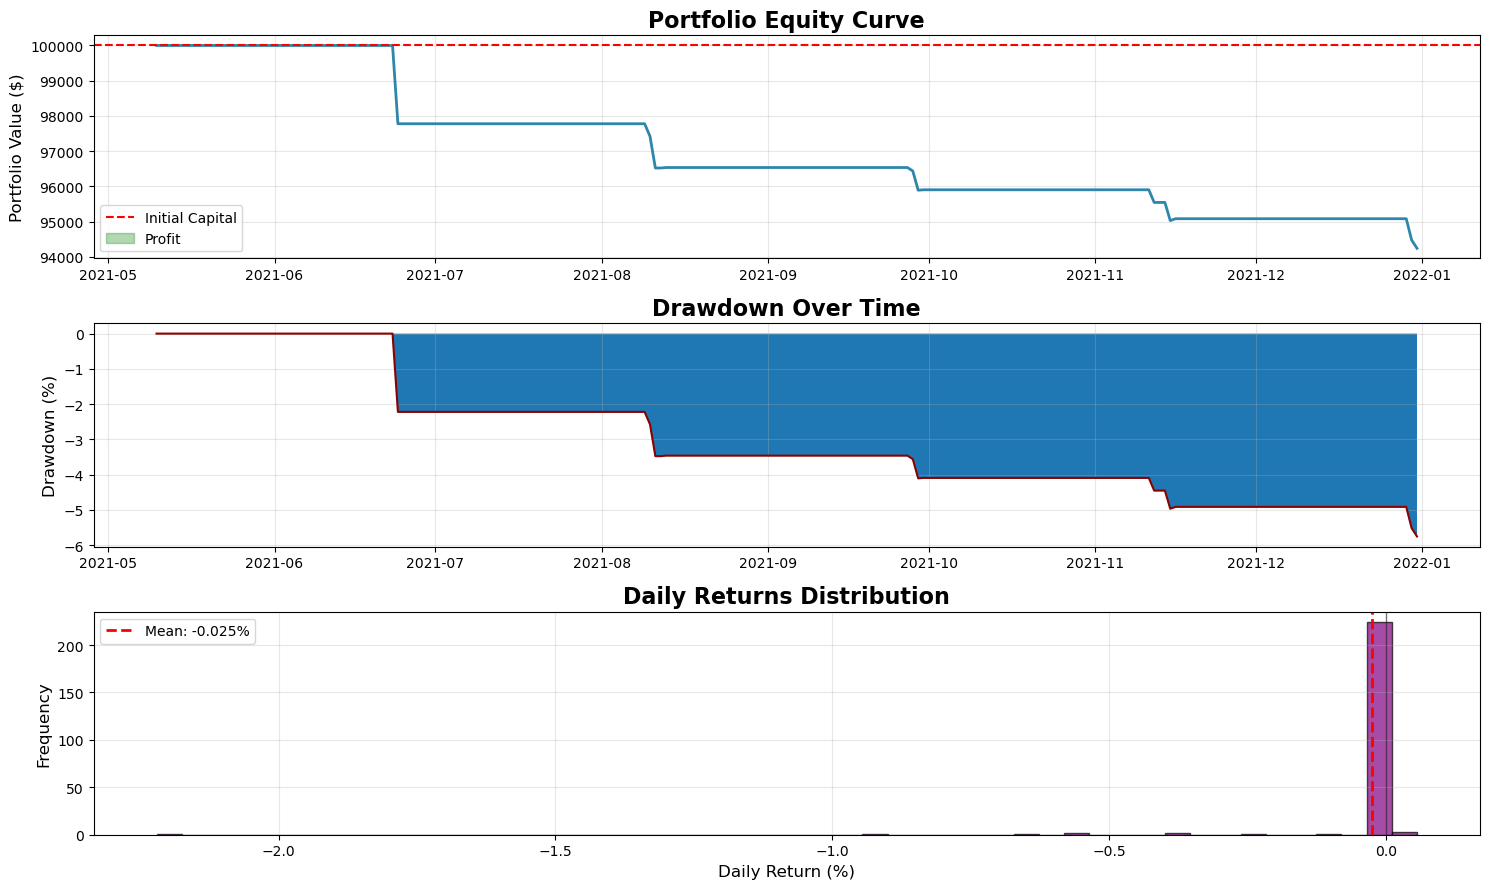

In [18]:
fig, axes = plt.subplots(3,1, figsize=(15,9))

axes[0].plot(equity_curve.index, equity_curve["equity"], linewidth=2, color="#2E86AB")
axes[0].axhline(y=100000, color="red", linestyle="--", linewidth=1.5, label="Initial Capital")
axes[0].fill_between(equity_curve.index, 100000, equity_curve["equity"],
                     where=(equity_curve["equity"]>=100000), alpha=0.3, color="green", label="Profit")
axes[0].set_title('Portfolio Equity Curve', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Portfolio Value ($)', fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style='plain', axis='y')

cumulative_returns = equity_curve["equity"] / equity_curve["equity"].iloc[0]
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max * 100
axes[1].fill_between(drawdown.index, drawdown)
axes[1].plot(drawdown.index, drawdown, color="darkred", linewidth=1.5)
axes[1].set_title('Drawdown Over Time', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)

daily_returns = equity_curve["returns"].dropna() * 100
axes[2].hist(daily_returns, bins=50, alpha=0.7, color="purple", edgecolor="black")
axes[2].axvline(daily_returns.mean(), color="red", linestyle="--", linewidth=2, label=f'Mean: {daily_returns.mean():.3f}%')
axes[2].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[2].set_title('Daily Returns Distribution', fontsize=16, fontweight='bold')
axes[2].set_xlabel('Daily Return (%)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### Rolling Performance Metrics

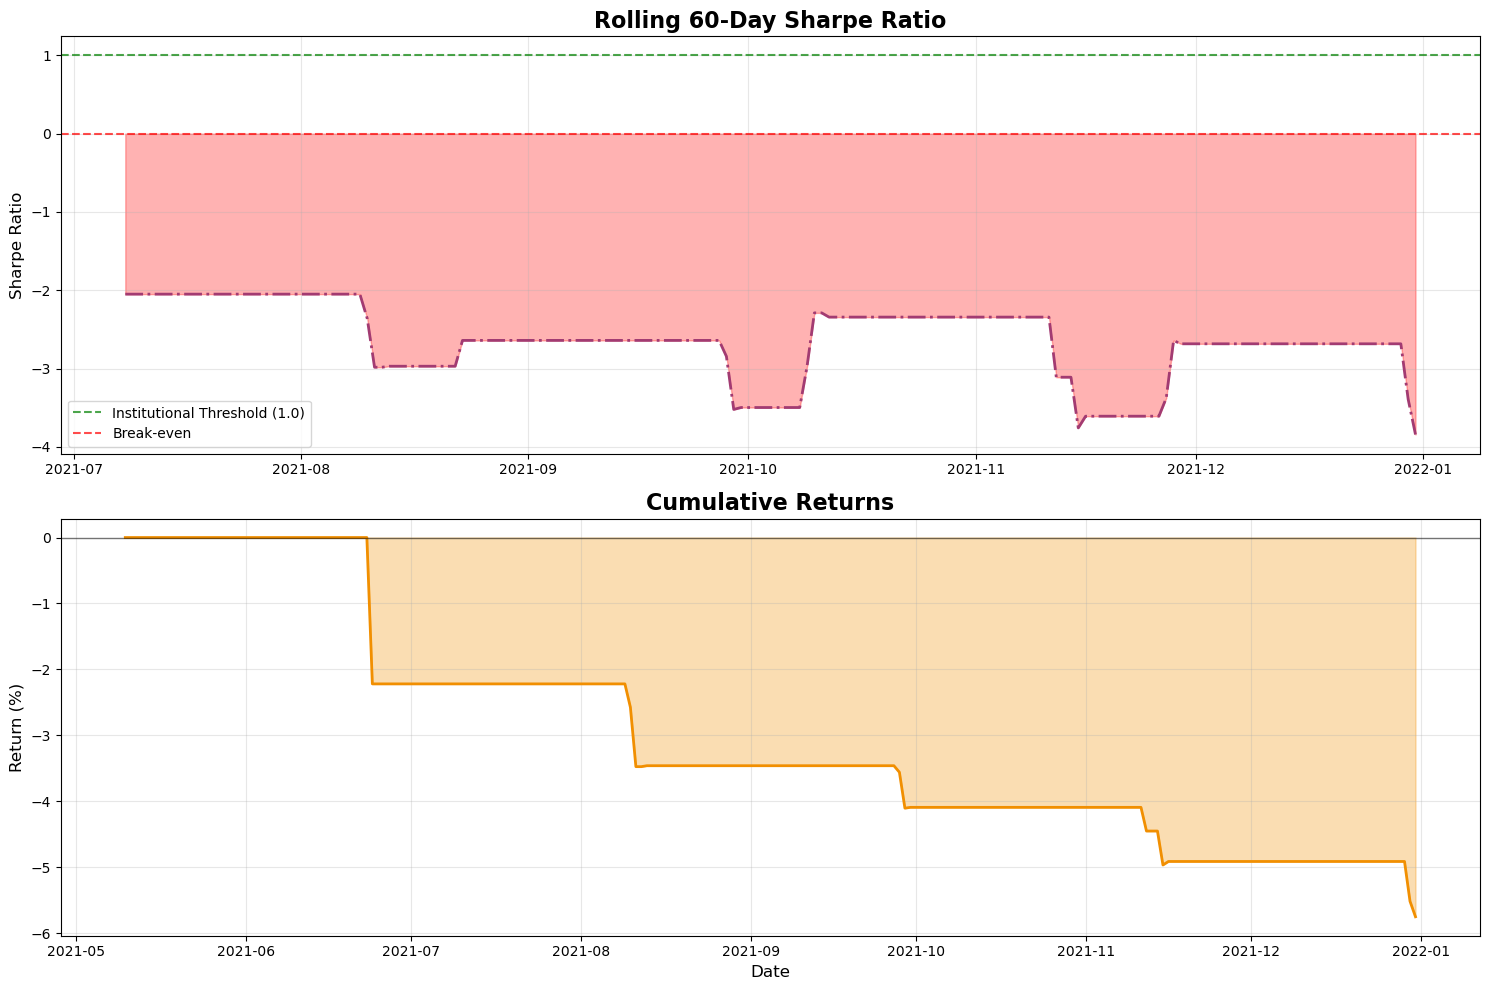

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(15,10))

rolling_returns = equity_curve["returns"].rolling(window=60)
rolling_sharpe = (rolling_returns.mean() / rolling_returns.std()) * np.sqrt(252)
axes[0].plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, linestyle="-.", color="#A23B72")
axes[0].axhline(y=1.0, color='green', linestyle='--', linewidth=1.5, label='Institutional Threshold (1.0)', alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1.5, label='Break-even', alpha=0.7)
axes[0].fill_between(rolling_sharpe.index, 0, rolling_sharpe, 
                     where=(rolling_sharpe >= 1.0), alpha=0.3, color='green')
axes[0].fill_between(rolling_sharpe.index, 0, rolling_sharpe, 
                     where=(rolling_sharpe < 0), alpha=0.3, color='red')
axes[0].set_title('Rolling 60-Day Sharpe Ratio', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Sharpe Ratio', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

cumulative_pct = (cumulative_returns -1) * 100
axes[1].plot(cumulative_pct.index, cumulative_pct, linewidth=2, color="#F18F01")
axes[1].fill_between(cumulative_pct.index, 0, cumulative_pct, alpha=0.3, color='#F18F01')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_title('Cumulative Returns', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Return (%)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [20]:
trades_df

,pair,entry_date,exit_date,position,holding_days,shares_etf1,shares_etf2,notional,entry_spread,exit_spread,gross_pnl,transaction_costs,net_pnl,return_pct,allowed
0,VEU_VWO,2021-05-10,2021-06-24,Long,45,31.926435,32.754584,3249.887686,9.366516,8.716583,-22.120161,3.249888,-25.370049,-0.780644,True
1,VOO_RIO,2021-05-10,2021-06-24,Short,45,0.405767,2.003423,276.599584,294.753853,308.324036,-606.000397,0.276600,-606.276996,-219.189410,True
2,SPY_RIO,2021-05-10,2021-06-24,Short,45,0.342231,1.836584,254.033670,327.405128,341.681854,-615.525279,0.254034,-615.779313,-242.400668,True
3,CRM_XLV,2021-05-10,2021-06-24,Short,45,0.692704,2.575087,444.249897,96.082962,124.360329,-264.578502,0.444250,-265.022752,-59.656233,True
4,ADBE_XLV,2021-05-10,2021-06-24,Short,45,0.207410,1.895530,318.514439,363.799515,461.387886,-707.653180,0.318514,-707.971695,-222.273030,True
13,VEU_VWO,2021-06-25,2021-08-10,Short,46,33.101214,33.959836,3478.920792,8.542530,10.313404,-350.911120,3.478921,-354.390041,-10.186781,True
14,EFA_VWO,2021-06-28,2021-08-11,Short,44,16.430003,19.278719,2074.639074,22.440308,26.290421,-502.994723,2.074639,-505.069362,-24.344927,True
15,ADBE_XLV,2021-06-28,2021-08-11,Long,44,0.140651,1.285413,233.956524,471.218018,502.909409,-1.883025,0.233957,-2.116982,-0.904861,True
16,EFA_EEM,2021-06-28,2021-08-11,Short,44,15.418659,16.285926,1902.720293,19.857136,24.136993,-391.920901,1.902720,-393.823622,-20.697925,True
17,XLB_EWJ,2021-06-30,2021-08-13,Long,44,5.883771,7.274751,899.560724,12.993420,15.774475,14.945981,0.899561,14.046420,1.561475,True


##### Trade-Level Analysis

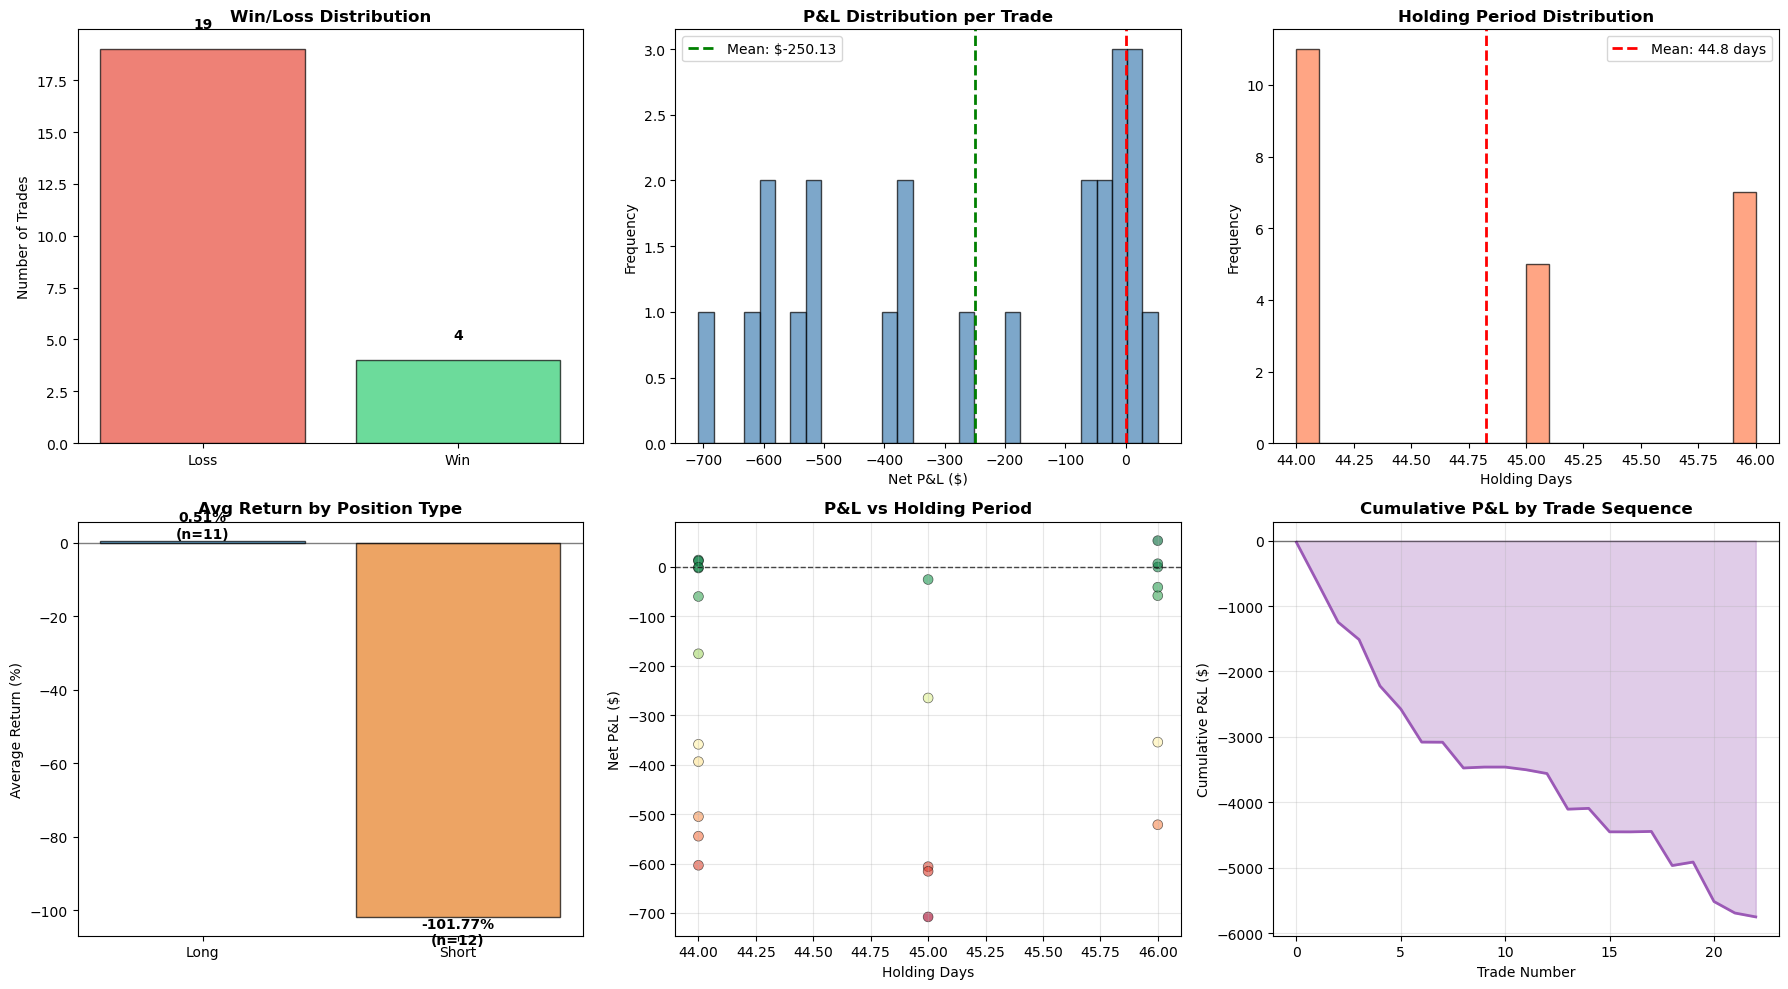

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18,10))

# Win/Loss Distribution
win_loss = trades_df["net_pnl"].apply(lambda x: "Win" if x>0 else "Loss")
win_loss_count = win_loss.value_counts()
colors_wl = ["#2ecc71" if x == "Win" else "#e74c3c" for x in win_loss_count.index] 
axes[0,0].bar(win_loss_count.index, win_loss_count.values, color=colors_wl, alpha=0.7, edgecolor="black")
axes[0, 0].set_title('Win/Loss Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Trades', fontsize=10)
for i,v in enumerate(win_loss_count.values):
    axes[0,0].text(i, v+1, str(v), ha="center", fontweight="bold")

# P&L distribution
axes[0, 1].hist(trades_df['net_pnl'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].axvline(trades_df['net_pnl'].mean(), color='green', linestyle='--', linewidth=2, 
                   label=f"Mean: ${trades_df['net_pnl'].mean():.2f}")
axes[0, 1].set_title('P&L Distribution per Trade', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Net P&L ($)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].legend()

# Holding period distribution
axes[0, 2].hist(trades_df['holding_days'], bins=20, alpha=0.7, color='coral', edgecolor='black')
axes[0, 2].axvline(trades_df['holding_days'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f"Mean: {trades_df['holding_days'].mean():.1f} days")
axes[0, 2].set_title('Holding Period Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Holding Days', fontsize=10)
axes[0, 2].set_ylabel('Frequency', fontsize=10)
axes[0, 2].legend()

# Return % by position type (Long vs Short)
position_returns = trades_df.groupby("position")["return_pct"].agg(["mean", "count"])
axes[1, 0].bar(position_returns.index, position_returns['mean'], 
               color=['#3498db', '#e67e22'], alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Avg Return by Position Type', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average Return (%)', fontsize=10)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
for i, (idx, row) in enumerate(position_returns.iterrows()):
    axes[1, 0].text(i, row['mean'], f"{row['mean']:.2f}%\n(n={int(row['count'])})", 
                    ha='center', va='bottom' if row['mean'] > 0 else 'top', fontweight='bold')

# P&L by holding period
axes[1, 1].scatter(trades_df['holding_days'], trades_df['net_pnl'], 
                   alpha=0.6, c=trades_df['net_pnl'], cmap='RdYlGn', s=50, edgecolors='black', linewidth=0.5)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.7)
axes[1, 1].set_title('P&L vs Holding Period', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Holding Days', fontsize=10)
axes[1, 1].set_ylabel('Net P&L ($)', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

# Cumulative P&L over trades
trades_sorted = trades_df.sort_values('entry_date')
cumulative_pnl = trades_sorted['net_pnl'].cumsum()
axes[1, 2].plot(range(len(cumulative_pnl)), cumulative_pnl, linewidth=2, color='#9b59b6')
axes[1, 2].fill_between(range(len(cumulative_pnl)), 0, cumulative_pnl, alpha=0.3, color='#9b59b6')
axes[1, 2].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1, 2].set_title('Cumulative P&L by Trade Sequence', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Trade Number', fontsize=10)
axes[1, 2].set_ylabel('Cumulative P&L ($)', fontsize=10)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

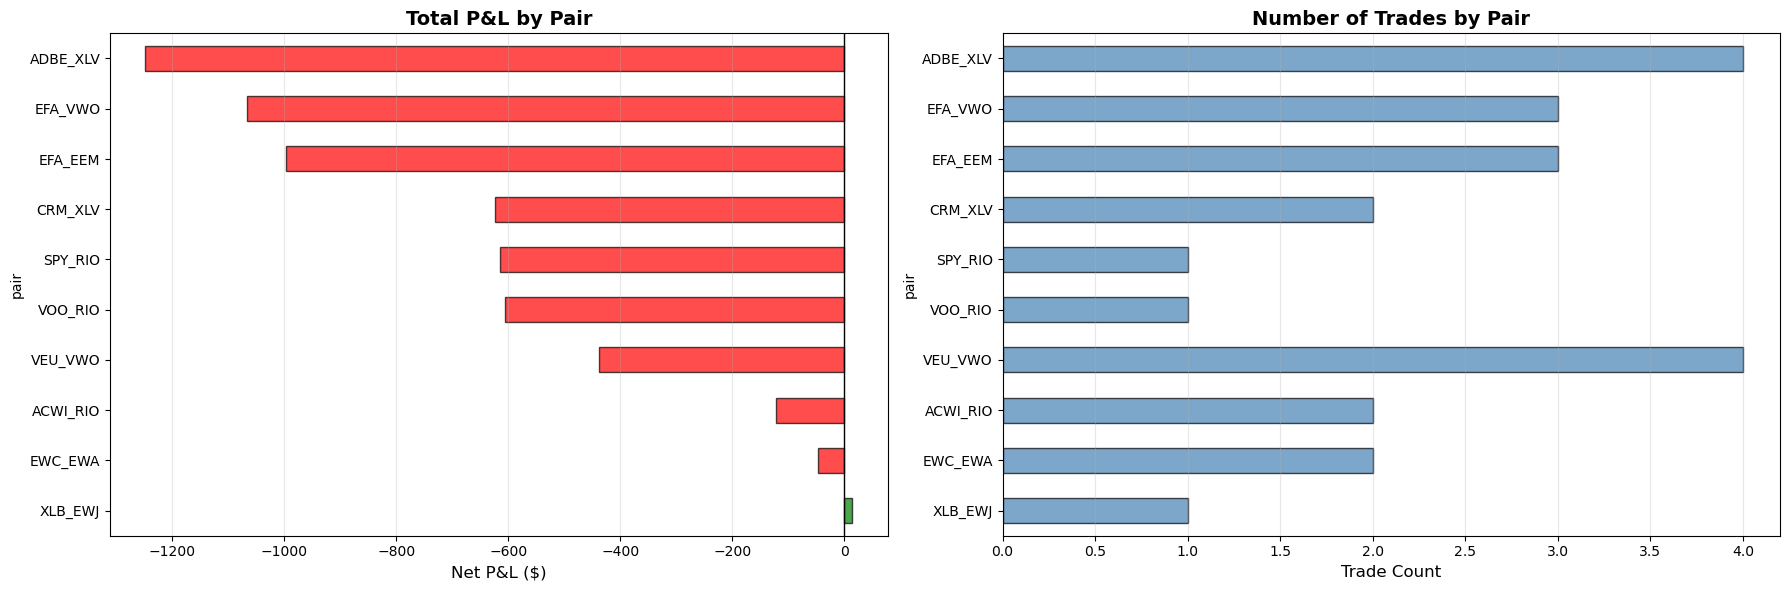

In [22]:
# P&L and Trade Count by Pair
pair_stats = trades_df.groupby('pair').agg({
    'net_pnl': ['sum', 'mean', 'count'],
    'return_pct': 'mean',
    'holding_days': 'mean'
}).round(2)

pair_stats.columns = ['Total P&L', 'Avg P&L', 'Trades', 'Avg Return %', 'Avg Days']
pair_stats = pair_stats.sort_values('Total P&L', ascending=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Total P&L by pair
colors_pair = ['green' if x > 0 else 'red' for x in pair_stats['Total P&L']]
pair_stats['Total P&L'].plot(kind='barh', ax=axes[0], color=colors_pair, alpha=0.7, edgecolor='black')
axes[0].set_title('Total P&L by Pair', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Net P&L ($)', fontsize=12)
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='x')

# Number of trades by pair
pair_stats['Trades'].plot(kind='barh', ax=axes[1], color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_title('Number of Trades by Pair', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Trade Count', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

##### Monthly/Yearly Performance Heatmap

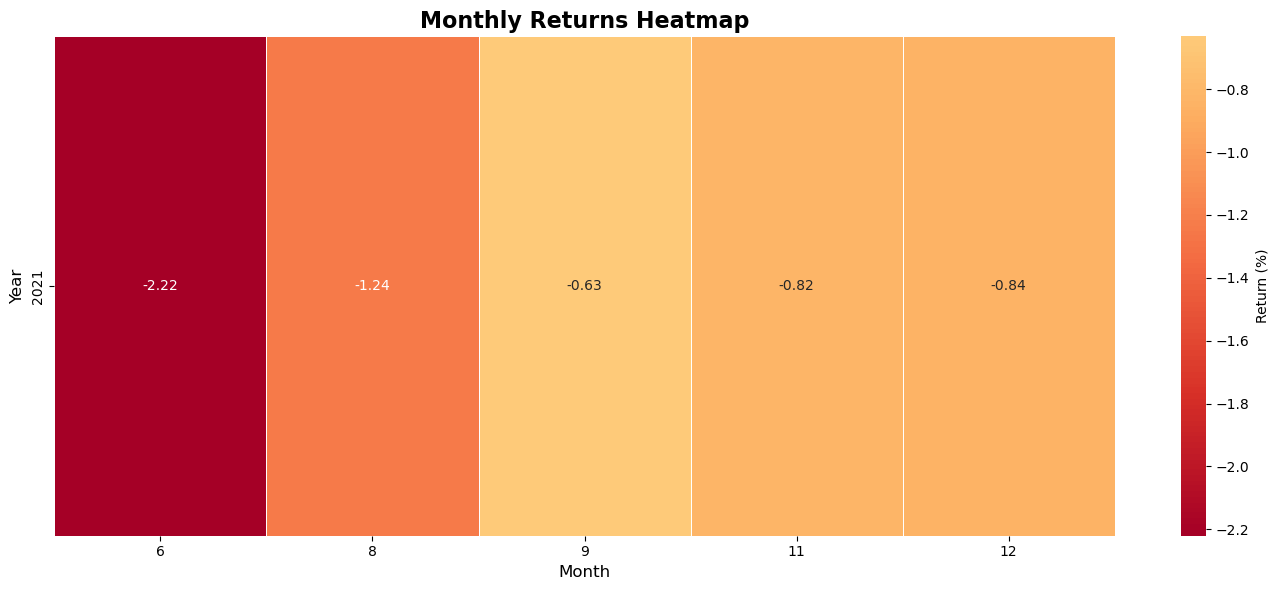

In [23]:
# Create monthly returns
trades_with_month = trades_df.copy()
trades_with_month['exit_month'] = pd.to_datetime(trades_with_month['exit_date']).dt.to_period('M')
monthly_pnl = trades_with_month.groupby('exit_month')['net_pnl'].sum()

# Convert to returns (approximate - uses initial capital)
monthly_returns = monthly_pnl / 100000 * 100

# Create pivot for heatmap
monthly_df = monthly_returns.to_frame('returns')
monthly_df.index = monthly_df.index.to_timestamp()
monthly_df['Year'] = monthly_df.index.year
monthly_df['Month'] = monthly_df.index.month

pivot = monthly_df.pivot_table(values='returns', index='Year', columns='Month', aggfunc='sum')

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Return (%)'}, linewidths=0.5)
plt.title('Monthly Returns Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
backtester.print_summary()


BACKTEST RESULTS

Trade Statistics:
  Total Trades: 23
  Winning Trades: 4 (17.4%)
  Losing Trades: 19
  Average Win: $21.54
  Average Loss: $-307.32
  Profit Factor: 0.07
  Avg Holding Period: 44.8 days

Portfolio Performance:
  Total P&L: $-5,752.99
  Total Return: -5.75%
  Transaction Costs: $45.05

Risk-Adjusted Metrics:
  Sharpe Ratio: -2.30
  Sortino Ratio: -0.63
  Max Drawdown: -5.75%
  Calmar Ratio: -1.00

PER-PAIR BREAKDOWN
          Trades  Total P&L  Avg P&L  Avg Return %  Avg Days
pair                                                        
ACWI_RIO       2    -122.25   -61.13        -14.32     45.00
ADBE_XLV       4   -1248.19  -312.05       -120.33     44.75
CRM_XLV        2    -623.78  -311.89        -69.27     44.50
EFA_EEM        3    -997.43  -332.48        -14.42     44.67
EFA_VWO        3   -1067.44  -355.81        -16.91     45.33
EWC_EWA        2     -47.52   -23.76         -0.56     44.00
SPY_RIO        1    -615.78  -615.78       -242.40     45.00
VEU_VWO      

##### Overall Summary

In [25]:
metrics = backtester.calculate_metrics()

print("\n" + "="*80)
print("DETAILED STATISTICAL SUMMARY")
print("="*80)

print("\n1. OVERALL PERFORMANCE")
print("-" * 80)
print(f"Initial Capital:        ${equity_curve['equity'].iloc[0]:>15,.0f}")
print(f"Final Value:            ${equity_curve['equity'].iloc[-1]:>15,.2f}")
print(f"Total P&L:              ${metrics['total_pnl']:>15,.2f}")
print(f"Total Return:           {metrics['total_return_pct']:>15.2f}%")
print(f"Total Transaction Costs: ${metrics['total_transaction_costs']:>15,.2f}")
print(f"Net After Costs:        ${metrics['total_pnl'] - metrics['total_transaction_costs']:>15,.2f}")

print("\n2. RISK-ADJUSTED METRICS")
print("-" * 80)
print(f"Sharpe Ratio:           {metrics['sharpe_ratio']:>15.2f}")
print(f"Sortino Ratio:          {metrics['sortino_ratio']:>15.2f}")
print(f"Calmar Ratio:           {metrics['calmar_ratio']:>15.2f}")
print(f"Max Drawdown:           {metrics['max_drawdown_pct']:>15.2f}%")

print("\n3. TRADE STATISTICS")
print("-" * 80)
print(f"Total Trades:           {metrics['total_trades']:>15}")
print(f"Winning Trades:         {metrics['winning_trades']:>15} ({metrics['win_rate']*100:.1f}%)")
print(f"Losing Trades:          {metrics['losing_trades']:>15}")
print(f"Avg Win:                ${metrics['avg_win']:>15,.2f}")
print(f"Avg Loss:               ${metrics['avg_loss']:>15,.2f}")
print(f"Profit Factor:          {metrics['profit_factor']:>15.2f}")
print(f"Avg Holding Period:     {metrics['avg_holding_days']:>15.1f} days")

print("\n4. POSITION ANALYSIS")
print("-" * 80)
long_trades = trades_df[trades_df['position'] == 'Long']
short_trades = trades_df[trades_df['position'] == 'Short']
print(f"Long Positions:         {len(long_trades):>15} trades")
print(f"  - Win Rate:           {(long_trades['net_pnl'] > 0).sum() / len(long_trades) * 100:>15.1f}%")
print(f"  - Avg P&L:            ${long_trades['net_pnl'].mean():>15,.2f}")
print(f"Short Positions:        {len(short_trades):>15} trades")
print(f"  - Win Rate:           {(short_trades['net_pnl'] > 0).sum() / len(short_trades) * 100:>15.1f}%")
print(f"  - Avg P&L:            ${short_trades['net_pnl'].mean():>15,.2f}")

print("\n5. TOP PERFORMING PAIRS")
print("-" * 80)
print(pair_stats.head(5).to_string())

print("\n6. WORST PERFORMING PAIRS")
print("-" * 80)
print(pair_stats.tail(3).to_string())

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


DETAILED STATISTICAL SUMMARY

1. OVERALL PERFORMANCE
--------------------------------------------------------------------------------
Initial Capital:        $        100,000
Final Value:            $      94,247.01
Total P&L:              $      -5,752.99
Total Return:                     -5.75%
Total Transaction Costs: $          45.05
Net After Costs:        $      -5,798.04

2. RISK-ADJUSTED METRICS
--------------------------------------------------------------------------------
Sharpe Ratio:                     -2.30
Sortino Ratio:                    -0.63
Calmar Ratio:                     -1.00
Max Drawdown:                     -5.75%

3. TRADE STATISTICS
--------------------------------------------------------------------------------
Total Trades:                        23
Winning Trades:                       4 (17.4%)
Losing Trades:                       19
Avg Win:                $          21.54
Avg Loss:               $        -307.32
Profit Factor:                     0.0